# Skin Cancer Classification
- The dataset you will use contains images of malignant and benign oncological diseases. 
- Number of Classes = 3:
  - **Actinic Keratosis:** Dry scaly patches of skin that have been damaged by the sun.
  -  **Basal Cell Carcinoma:** The most common form of skin cancer it begins in the basal cells.
  - **Melanoma:** The most serious type of skin cancer, develops in the cells (melanocytes) that produce melanin — the pigment that gives your skin its color.


## Imports

In [109]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from PIL import Image

## Download Data

In [ ]:
!pip install --upgrade --no-cache-dir gdown

In [ ]:
!gdown "https://drive.google.com/uc?id=1Hyojd3qHkNg3nI7-EbOZiZHRss3C-HI8"

In [ ]:
!unzip /content/Data.zip

## Visualize Images

In [130]:
actinic_keratosis = Image.open("/content/Data/Train/actinic-keratosis/ISIC_0026212.jpg")
basal_cell_carcinoma = Image.open("/content/Data/Train/basal-cell-carcinoma/ISIC_0024848.jpg")
melanoma = Image.open("/content/Data/Train/melanoma/ISIC_0000139.jpg")

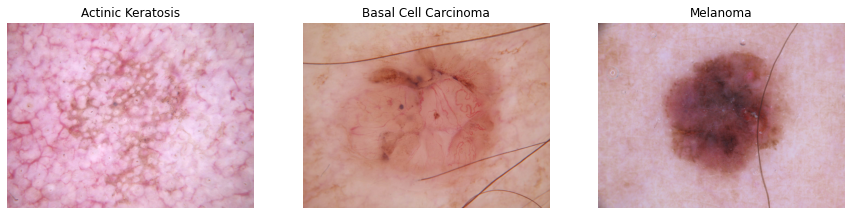

In [131]:
plt.figure(figsize=(15, 15))
i = 0
class_names = ["Actinic Keratosis","Basal Cell Carcinoma","Melanoma"]
images = [actinic_keratosis,basal_cell_carcinoma,melanoma]
for item in images:
  ax = plt.subplot(1, 3, i+1)
  plt.imshow(item)
  plt.title(class_names[i])
  plt.axis("off")
  i+=1

## Generate a train and test dataloader from the images files in the directory:
 - define the batch size to: 16
 - define image size to be: 224,224
 - hint: use image_dataset_from_directory method

In [161]:
BATCH_SIZE = 16
IMG_SIZE = (224, 224)

training = tf.keras.utils.image_dataset_from_directory(
    'Data/Train',
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE)
testing = tf.keras.utils.image_dataset_from_directory(
    'Data/Test',
    shuffle=True,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE)

Found 928 files belonging to 3 classes.
Found 48 files belonging to 3 classes.


## Split the train dataloader into train and validation
- **train:** 54 batches
- **valid:** 4 batches 

In [162]:
validation = training.take(4)
training = training.skip(4)

In [163]:
print(f"training batches: {tf.data.experimental.cardinality(training)}")
print(f"training batches: {tf.data.experimental.cardinality(validation)}")

training batches: 54
training batches: 4


## Define an augmentation Layer 
 - Use ```RandomFlip``` layer and set it to ```horizontal_and_vertical```
 - Use ```RandomRotation``` layer and set it to ```0.2```
 - Use ```RandomZoom``` layer and set it to ```0.2```


In [164]:
augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2)
])

## Define a layer to use the same preprocessing as the pretrained model ([VGG16](https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/VGG16)):


In [165]:
preprocess = tf.keras.applications.vgg16.preprocess_input

## Download the pretrained model
- Don't forget to not include the classification layer

In [185]:
IMG_SHAPE = (224, 224, 3)

base_model = tf.keras.applications.vgg16.VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=IMG_SHAPE
)

base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Un-Freeze the top layers of the base model

In [186]:
base_model.trainable = True

for layer in base_model.layers[:17]:
  layer.trainable=False

base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Create a Flatten layer to convert the feature map to 1D vector

Note to self: We have (n_samples, height, width, channels)

Flatten reshapes  into (n_samples, height* width* channels)

GlobalAveragePooling reshapes into (n_samples, channels)

In [187]:
img_batch, lbl_batch = next(iter(training))
print(img_batch.shape, lbl_batch.shape)
feature_batch = base_model(img_batch)
print(feature_batch.shape)

global_avg_layer = tf.keras.layers.GlobalAveragePooling2D()

feature_batch_avg = global_avg_layer(feature_batch)
print(feature_batch_avg.shape)

(16, 224, 224, 3) (16,)
(16, 7, 7, 512)
(16, 512)


## Create a dropout layer

In [188]:
dropout = tf.keras.layers.Dropout(0.2)

## Create a Predication Layer
 [Dense Layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)
 - Set the number of units = 3 as you have 3 classes. 
 - The activation function softmax.


In [189]:
output_layer = tf.keras.layers.Dense(3)
# Note: I'm using softmax, note the from_logits=True in compilation

## Chain the layers to build the model

In [190]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = augmentation(inputs)
x = preprocess(x)
x = base_model(x, training=False)
x = global_avg_layer(x)
x = dropout(x)
outputs = output_layer(x)

model = tf.keras.Model(inputs, outputs)

## Compile the model
- Use [SparseCategoricalCrossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy) as the loss function.
- Use [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) as the optimizer with ```0.0001``` learning rate.
- Use ```Accuracy``` as the metric for evaluation.

In [191]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)
model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_24 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 sequential_8 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_10  (None, 224, 224, 3)      0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_10 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_9   (None, 512)              0   

## Train the model
- Number of epochs =  ```5```

In [192]:
hist = model.fit(training, epochs=5, validation_data=validation)

Epoch 1/5


54/54 [==============================] - 15s 179ms/step - loss: 0.9197 - accuracy: 0.7002 - val_loss: 0.6038 - val_accuracy: 0.8281
Epoch 2/5
54/54 [==============================] - 11s 175ms/step - loss: 0.5174 - accuracy: 0.8264 - val_loss: 0.5433 - val_accuracy: 0.8438
Epoch 3/5
54/54 [==============================] - 10s 172ms/step - loss: 0.4034 - accuracy: 0.8507 - val_loss: 0.3405 - val_accuracy: 0.8438
Epoch 4/5
54/54 [==============================] - 9s 156ms/step - loss: 0.3007 - accuracy: 0.8762 - val_loss: 0.5702 - val_accuracy: 0.8125
Epoch 5/5
54/54 [==============================] - 11s 165ms/step - loss: 0.2768 - accuracy: 0.8981 - val_loss: 0.2367 - val_accuracy: 0.9062


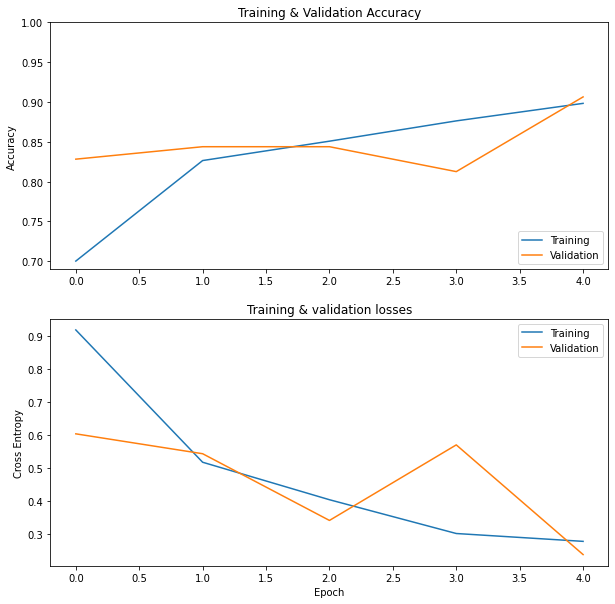

In [193]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(acc, label='Training')
plt.plot(val_acc, label='Validation')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training & Validation Accuracy')

plt.subplot(2,1,2)
plt.plot(loss, label='Training')
plt.plot(val_loss, label='Validation')
plt.legend()
plt.ylabel('Cross Entropy')
# plt.ylim([0,1.0])
plt.title('Training & validation losses')
plt.xlabel('Epoch')
plt.show()

## Evaluate the model on test set

In [194]:
loss, accuracy = model.evaluate(testing)
print(f'Testing\nloss: {loss}\naccuracy: {accuracy}')

3/3 [==============================] - 0s 67ms/step - loss: 1.4726 - accuracy: 0.7500
Testing
loss: 1.4726215600967407
accuracy: 0.75
